## Solution Approach

A mathematical optimization model has five components, namely:

* Sets and indices.
* Parameters.
* Decision variables.
* Objective function(s).
* Constraints.

## Model Formulation

### Sets and Indices

$G(N,E)$: Graph that represents the airport network, where $N$ is the set of vertices and $E$ is the set of edges. The sirports are vertices in the set of nodes $N$ of the graph. The set of flight paths are the edges of the graph.(we assume there is a flight path between each pair of airports) 

### Parameters
$d_{i,j} \in \mathbb{R}^+ $:haversine distance from vertex $i \in N$ to vertex $j \in N$.



### Decision Variables
$x_{ij} = \begin{cases} 
1 & \text{if arc from node } i \text{ to node } j \text{ is traversed, } i \neq j; \\
0 & \text{otherwise.}
\end{cases}$


## Miller-Tucker-Zemlin TSP Formulation
# 
### Objective Function
Minimize the total distance traveled:
# 
$$
\min \sum_{i \in N} \sum_{j \in N} d_{ij} x_{ij}
$$
# 
### Constraints
1. Each node must be departed from exactly once:
$$
\sum_{j \in N, j \neq i} x_{ij} = 1 \quad \forall i \in N
$$
2. Each node must be arrived at exactly once:
$$
\sum_{i \in N, i \neq j} x_{ij} = 1 \quad \forall j \in N
$$
3. Subtour elimination constraints:
$$
u_i - u_j + (n-1)x_{ij} \leq n-2 \quad \forall i \in N, j \in N, i \neq j, i \neq 1
$$
4. No self-loops:
$$
x_{ii} = 0 \quad \forall i \in N
$$
5. Binary constraints on decision variables:
$$
x_{ij} \in \{0, 1\} \quad \forall i \in N, j \in N, i \neq j
$$
6. Order constraints:
$$
u_1 = 1
$$
$$
2 \leq u_i \leq n \quad \forall i \in N, i \neq 1
$$
7. return to airport dummy constraint
$$x_{1,0}=1
$$



In [7]:
from pprint import pprint
import pandas as pd
import networkx as nx
from haversine import haversine, Unit

# Load the data
data = pd.read_csv('airports.csv')
# Add one to the first column value
data['Unnamed: 0'] = data['Unnamed: 0'] + 1

# Create a graph
G = nx.Graph()

# Add nodes
for index, row in data.iterrows():
    G.add_node(row['Unnamed: 0'], country=row['country'], airport_name=row['airport_name'], airport_code=row['airport_code'], latitude_deg=row['latitude_deg'], longitude_deg=row['longitude_deg'])

# Add edges with haversine distance as weight
for i, row1 in data.iterrows():
    for j, row2 in data.iterrows():
        if i != j:
            coord1 = (row1['latitude_deg'], row1['longitude_deg'])
            coord2 = (row2['latitude_deg'], row2['longitude_deg'])
            distance = haversine(coord1, coord2, unit=Unit.KILOMETERS)
            G.add_edge(row1['Unnamed: 0'], row2['Unnamed: 0'], weight=distance)

print(G)

Graph with 45 nodes and 990 edges


In [8]:
from gurobipy import *
import gurobipy as gp
import numpy as np
import random

import matplotlib.pyplot as plt
import networkx as nx
# Create a new model
mtz = gp.Model("TSP_MTZ")
mtz.Params.MIPGap = 0.13  # Set the target accuracy to 5% of the optimal

# Create variables
vars = mtz.addVars([(i, j) for i in G.nodes for j in G.nodes if i != j],
                     vtype=GRB.BINARY, name="e")

# Subtour elimination decision variables
u = mtz.addVars(G.nodes, vtype=GRB.CONTINUOUS, name="u", lb=1, ub=len(G.nodes))

# Objective: minimize the total distance traveled
mtz.setObjective(gp.quicksum(vars[i, j] * G[i][j]['weight'] 
                               for i in G.nodes for j in G.nodes if i != j), GRB.MINIMIZE)

# Constraints
# Each node is entered and left exactly once
for i in G.nodes:
    mtz.addConstr(gp.quicksum(vars[i, j] for j in G.nodes if i != j) == 1)
    mtz.addConstr(gp.quicksum(vars[j, i] for j in G.nodes if i != j) == 1)

# Subtour elimination constraints (MTZ)
for i in list(G.nodes)[1:]:
    for j in list(G.nodes)[1:]:
        if i != j:
            mtz.addConstr(u[i] + 1 <= u[j] + (len(G.nodes) - 1) * (1 - vars[i, j]))

mtz.addConstr(u[1] == 1)  # Fix the position of the first node

# order constraint
for i in list(G.nodes)[1:]:
    mtz.addConstr(u[i] >= 2)
    mtz.addConstr(u[i] <= len(G.nodes))

# return to airport dummy constraint
mtz.addConstr(vars[2, 1] == 1)


# Solve the model
mtz.optimize()

# Output the solution
if mtz.status == GRB.OPTIMAL:
    edges = [(i, j) for i in G.nodes for j in G.nodes if i != j and vars[i, j].X > 0.5]
    print("Optimal tour:", edges)
else:
    print("No optimal solution found")

Set parameter MIPGap to value 0.13
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 2072 rows, 2025 columns and 9726 nonzeros
Model fingerprint: 0xce888578
Variable types: 45 continuous, 1980 integer (1980 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [1e+02, 2e+04]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 135 rows and 89 columns
Presolve time: 0.01s
Presolved: 1937 rows, 1936 columns, 9290 nonzeros
Variable types: 43 continuous, 1893 integer (1893 binary)
Found heuristic solution: objective 220963.70481
Found heuristic solution: objective 216616.13600

Root relaxation: objective 3.812329e+04, 148 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    

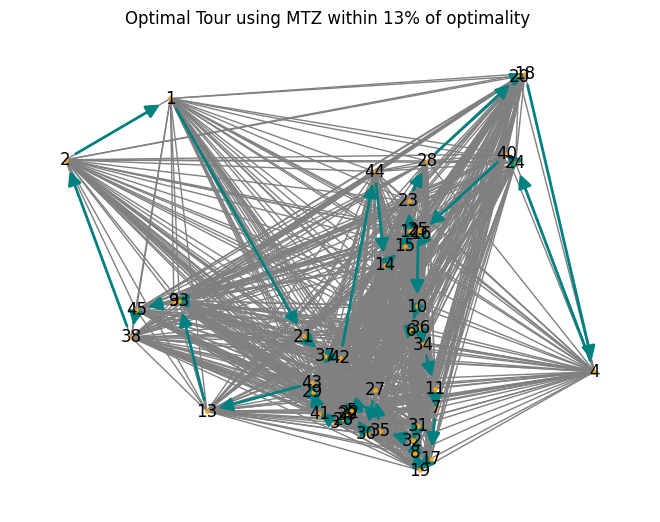

In [9]:
# Define the optimal tour provided by gurobi
optimal_tour = edges

# Draw the network with the optimal path highlighted
G_optimal = nx.DiGraph()
G_optimal.add_edges_from(optimal_tour)
# Define the positions of the nodes based on latitude and longitude
pos = {node: (G.nodes[node]['longitude_deg'], G.nodes[node]['latitude_deg']) for node in G.nodes}

# Draw the full graph with all nodes
nx.draw(G, pos, with_labels=True, node_color='orange', node_size=5, edge_color='gray', arrows=True)

# Overlay the optimal tour with a different edge color
nx.draw_networkx_edges(G_optimal, pos, edge_color='teal', width=2, arrows=True, arrowstyle='-|>', arrowsize=20)

plt.title('Optimal Tour using MTZ within 13% of optimality ')
plt.show()